### Mobysound whale custom parsing
- This is a series of datasets with whale/dolphin echolocation clicks. They are all available on Mobysound. 
    - WAV files for vocalization that contains labels for species and vocalization. 
- This notebook creates a JSON corresponding to each WAV file.
- Dataset origin:
    - https://www.mobysound.org/

In [7]:
from avgn.utils.general import prepare_env

In [8]:
prepare_env()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=GPU


### Import relevant packages

In [9]:
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm
import pandas as pd
pd.options.display.max_columns = None
import librosa
from datetime import datetime
import numpy as np
import re

In [10]:
import avgn
from avgn.custom_parsing.picidae_woodpecker import generate_json
from avgn.utils.paths import DATA_DIR

### Load data in original format

In [11]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-06-25_13-20-58'

In [62]:
subfolders = {
        'Melon headed whale':{
            'folder': 'MellonHeaded_MTSTCS',
            'species': 'Peponocephala electra',
            'split': '.',
            'click_types' : [
                            ['good', '*Good.txt']
                        ]
        },
        'Sperm whale':{
            'folder': 'Sperm whales_Bahamas(AUTEC)-Annotated/',
            'species': 'Peponocephala electra',
            'split': '_',
            'click_types' : [
                            ['maybe', '*maybe.txt'],
                            ['good', '*short_good.txt']
                        ]
        },
        'Pilot whale':{
            'folder': 'Pilot_whales_Bahamas(AUTEC)-Annotated-NUWC',
            'species': 'Peponocephala electra',
            'split': '_',
            'click_types' : [
                                ['good', '*good.txt'],
                                ['maybe', '*maybe1.txt']
                        ]
        },
        'Risos whale':{
            'folder': 'Rissos-SCORE-annot',
            'species': 'Peponocephala electra',
            'click_types' : [
                            ['good', '*GoodSingle.txt'],
                            ['poor', '*PoorSingle.txt'],
                        ]
        },
        'Pacific whitesided dolphin':{
            'folder': 'PacWhitesidedDolphin',
            'split': '.',
            'species': 'Peponocephala electra',
            'click_types' : [
                            ['type1h', '*type 1h.txt.txt']
                        ]
        },
        'Blainsville\'s beaked whale':{
            'folder': 'Mesoplodon_Bahamas(AUTEC)-Annotated',
            'split': '.',
            'species': 'Peponocephala electra',
            'click_types' : [
                            ['good', '*/*on_final.log'],
                            ['maybe', '*/*maybe_final.log'],
                        ]
        }
}

In [63]:
DSLOC = avgn.utils.paths.Path('/mnt/cube/Datasets/mobysound/')
DSLOC

PosixPath('/mnt/cube/Datasets/mobysound')

### create JSON for each species

In [64]:
from avgn.utils.audio import get_samplerate

In [65]:
for common_name, species_dict in subfolders.items():
    break

In [66]:
species_dict

{'folder': 'MellonHeaded_MTSTCS',
 'species': 'Peponocephala electra',
 'split': '.',
 'click_types': [['good', '*Good.txt']]}

In [67]:
ds_folder = DSLOC / species_dict['folder']
ds_folder

PosixPath('/mnt/cube/Datasets/mobysound/MellonHeaded_MTSTCS')

In [68]:
species_dict

{'folder': 'MellonHeaded_MTSTCS',
 'species': 'Peponocephala electra',
 'split': '.',
 'click_types': [['good', '*Good.txt']]}

In [69]:
wavs = list(ds_folder.glob('*.wav'))
len(wavs)

5

In [70]:
wav_df = pd.DataFrame(columns = ['stem', 'path', 'rate', 'duration'])
for wav in wavs:
    sr = get_samplerate(wav.as_posix())
    wav_duration = librosa.get_duration(filename=wav)
    wav_df.loc[len(wav_df)] = [wav.stem, wav, sr, wav_duration]

In [71]:
wav_df

,stem,path,rate,duration
0,MISTCS070124-114000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,600.000
1,MISTCS070124-112000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,600.000
2,MISTCS070124-113934,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,25.750
3,MISTCS070124-113000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,536.067
4,MISTCS070124-111000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,600.000


In [72]:
click_label_loc

PosixPath('/mnt/cube/Datasets/mobysound/MellonHeaded_MTSTCS/MISTCS070124-112000-Good.txt')

In [88]:
clicks_df = []
for click_type, click_type_glob in species_dict['click_types']:
    good_clicks = list(ds_folder.glob(click_type_glob))
    good_clicks = [i for i in good_clicks if i.stem[0] != '.']
    for click_label_loc in good_clicks:
        good_clicks_df = pd.read_csv(click_label_loc, delimiter='\t')
        good_clicks_df['stem'] = click_label_loc.stem
        good_clicks_df['click_value'] = click_type
        clicks_df.append(good_clicks_df)
clicks_df = pd.concat(clicks_df)
clicks_df.columns = [re.sub(' +', ' ', i) for i in clicks_df.columns]

clicks_df['stem'] = [i.split(species_dict['split'])[0] for i in clicks_df.stem]

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [89]:
clicks_df[:3]

,end time,low freq,high freq,peak freq,centr. freq,end time,high freq,% start time,%start time,Unnamed: 6,centr. freq,click_value,low freq,peak freq,stem
0,120.35451,11936.23522,47548.39651,88.32861,28750.62782,NaN,NaN,120.35314,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
1,120.43898,13613.61962,47290.33737,89.91411,27392.97215,NaN,NaN,120.43770,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
2,121.30407,10258.85081,47419.36694,84.14929,22236.85906,NaN,NaN,121.30293,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000


In [90]:
len(clicks_df)

3642

In [91]:
clicks_df.columns

Index([' end time', ' low freq', ' high freq', ' peak freq', ' centr. freq',
       ' end time', ' high freq', '% start time', '%start time', 'Unnamed: 6',
       'centr. freq', 'click_value', 'low freq', 'peak freq', 'stem'],
      dtype='object')

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

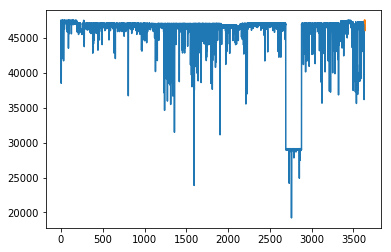

In [93]:
plt.plot(clicks_df[' high freq'].values)

In [94]:
clicks_df[:3]

,end time,low freq,high freq,peak freq,centr. freq,end time,high freq,% start time,%start time,Unnamed: 6,centr. freq,click_value,low freq,peak freq,stem
0,120.35451,11936.23522,47548.39651,88.32861,28750.62782,NaN,NaN,120.35314,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
1,120.43898,13613.61962,47290.33737,89.91411,27392.97215,NaN,NaN,120.43770,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
2,121.30407,10258.85081,47419.36694,84.14929,22236.85906,NaN,NaN,121.30293,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000


In [95]:
clicks_df.iloc[0][' low freq']

11936.23522

In [96]:
clicks_df.stem.unique()

array(['MISTCS070124-114000', 'MISTCS070124-113000',
       'MISTCS070124-112000-Good'], dtype=object)

In [99]:
clicks_df

,end time,low freq,high freq,peak freq,centr. freq,end time,high freq,% start time,%start time,Unnamed: 6,centr. freq,click_value,low freq,peak freq,stem
0,120.35451,11936.23522,47548.39651,88.32861,28750.62782,NaN,NaN,120.35314,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
1,120.43898,13613.61962,47290.33737,89.91411,27392.97215,NaN,NaN,120.43770,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
2,121.30407,10258.85081,47419.36694,84.14929,22236.85906,NaN,NaN,121.30293,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
3,122.20852,11807.20565,47161.30780,85.91473,24225.28827,NaN,NaN,122.20711,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
4,122.69287,14129.73790,38516.32661,77.44514,22436.92282,NaN,NaN,122.69194,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
5,122.85131,10903.99866,47161.30780,87.46372,23775.49487,NaN,NaN,122.85003,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
6,123.47992,10645.93952,47419.36694,87.85763,22351.64358,NaN,NaN,123.47868,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
7,123.54302,9871.76210,42774.30242,85.49382,21777.19285,NaN,NaN,123.54158,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
8,123.64292,9097.58468,44967.80511,87.22261,19723.65090,NaN,NaN,123.64172,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000
9,123.74013,9613.70296,42000.12500,86.09263,20457.36276,NaN,NaN,123.73892,NaN,NaN,NaN,good,NaN,NaN,MISTCS070124-114000


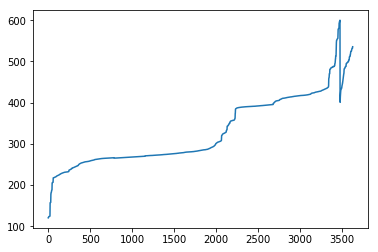

In [97]:
plt.plot(clicks_df[' end time'].values[:,0])

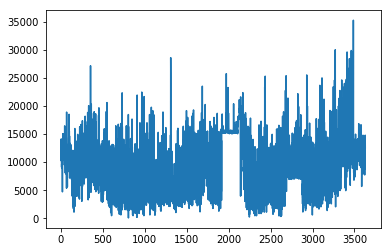

In [83]:
plt.plot(clicks_df[' low freq'].values)

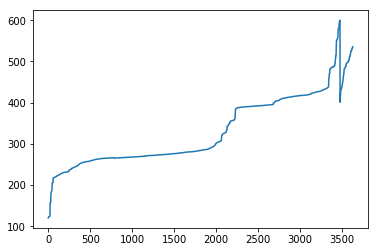

In [84]:
plt.plot(clicks_df['% start time'].values)

In [85]:
wav_df[:3]

,stem,path,rate,duration
0,MISTCS070124-114000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,600.00
1,MISTCS070124-112000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,600.00
2,MISTCS070124-113934,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000,25.75


In [86]:
for idx, wavrow in wav_df.iterrows():
    break

In [87]:
wavrow

stem                                      MISTCS070124-114000
path        /mnt/cube/Datasets/mobysound/MellonHeaded_MTST...
rate                                                    96000
duration                                                  600
Name: 0, dtype: object

In [49]:
common_name, species_dict

('Melon headed whale',
 {'folder': 'MellonHeaded_MTSTCS',
  'species': 'Peponocephala electra',
  'click_types': [['good', '*Good.txt']]})

In [59]:
json_dict = {}
json_dict["indvs"] = {
    "UNK": {}
}
# add species
json_dict["species"] = species_dict['species']
json_dict["common_name"] = common_name
json_dict["wav_loc"] = wavrow.path.as_posix()
json_dict["stem"] = wavrow.stem
# rate and length
json_dict["samplerate_hz"] = wavrow.rate
json_dict["length_s"] = wavrow.duration

In [ ]:
# dump json
json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)